In [3]:
import pandas as pd
bills_df = pd.read_csv('bills.csv') # sampled set
venues_df = pd.read_csv('venues.csv')

# add column for tip percentage (tip / billed)
bills_df['tip_percentage'] = bills_df.apply(lambda row: 100 * row['payment_total_tip'] / row['bill_total_billed'] if row['bill_total_billed'] != 0 else None, axis=1)
bills_df.loc[bills_df['tip_percentage'] > 100, 'tip_percentage'] = None

# merge dataframes
bills_venues_df = pd.merge(bills_df, venues_df, on='venue_xref_id')

# Order type vs. tip %

In [4]:
order_type_summary = bills_df.groupby('order_take_out_type_label').agg(
    average_bill_size=('bill_total_billed', 'mean'),
    average_tip_amount=('payment_total_tip', 'mean'),
    average_tip_percentage=('tip_percentage', 'mean'),
)

if 'order_duration_seconds' in bills_df.columns:
  order_duration_summary = bills_df.groupby('order_take_out_type_label').agg(
      average_order_duration=('order_duration_seconds', 'mean')
  )

  combined_summary = pd.merge(order_type_summary, order_duration_summary, on='order_take_out_type_label')
combined_summary


,average_bill_size,average_tip_amount,average_tip_percentage,average_order_duration
order_take_out_type_label,,,,
bartab,33.651211,4.134953,12.279253,6164.572074
delivery,40.712796,1.778602,3.446113,3158.188172
dinein,37.136564,4.025733,8.119651,2654.971456
onlineorder,38.679438,0.531592,1.224587,4586.679435
takeout,32.241844,1.247242,3.540825,2067.567404


# Holiday & Day of Week

In [5]:
!pip install holidays

import holidays

In [6]:
bills_df['bill_paid_at_local'] = pd.to_datetime(bills_df['bill_paid_at_local'])

bills_df['date'] = bills_df['bill_paid_at_local'].dt.date
bills_df['day_of_week'] = bills_df['bill_paid_at_local'].dt.day_name()

# Analyze sales by day of the week
day_of_week_sales = bills_df.groupby('day_of_week')['tip_percentage'].mean().reset_index().sort_values(by='tip_percentage', ascending=False)
print("\nTotal Sales by Day of the Week:\n", day_of_week_sales)

# Analyze sales by holiday
ca_holidays = holidays.CA()
us_holidays = holidays.US()

def get_holiday_name(date):
    """Returns the holiday name if the date is a holiday in CA or US, else returns None."""
    holiday_name = ca_holidays.get(date) or us_holidays.get(date)
    return holiday_name

bills_df['holiday_name'] = bills_df['date'].apply(get_holiday_name)

holiday_sales = bills_df.groupby(['date', 'holiday_name', 'day_of_week'])['tip_percentage'].mean().reset_index().sort_values(by='tip_percentage', ascending=False)
print("\nTotal Sales on Holidays:\n", holiday_sales)


Total Sales by Day of the Week:
   day_of_week  tip_percentage
2    Saturday        7.935840
0      Friday        7.884911
3      Sunday        7.553755
4    Thursday        7.460915
6   Wednesday        7.431080
5     Tuesday        7.049846
1      Monday        6.768445

Total Sales on Holidays:
          date      holiday_name day_of_week  tip_percentage
7  2025-01-01    New Year's Day   Wednesday        9.741582
5  2024-11-28      Thanksgiving    Thursday        8.112006
2  2024-09-02         Labor Day      Monday        7.930092
4  2024-11-11      Veterans Day      Monday        7.759456
1  2024-07-04  Independence Day    Thursday        6.911251
0  2024-07-01        Canada Day      Monday        6.849331
6  2024-12-25     Christmas Day   Wednesday        6.664546
3  2024-10-14      Columbus Day      Monday        6.013803


# Time of Day vs Tip %

In [7]:
import matplotlib.pyplot as plt

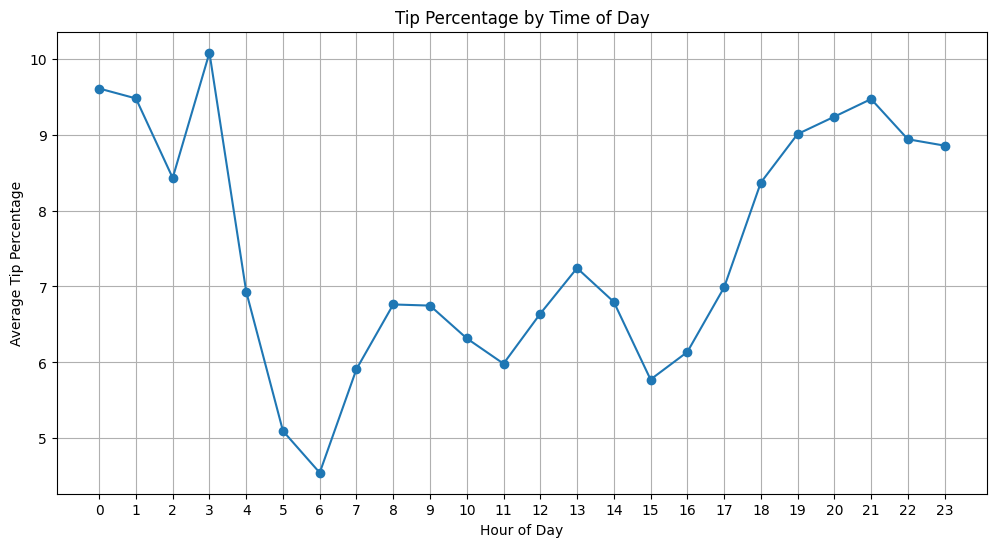

In [8]:
bills_df['bill_paid_at_local'] = pd.to_datetime(bills_df['bill_paid_at_local'])
bills_df['hour_of_day'] = bills_df['bill_paid_at_local'].dt.hour

time_of_day_summary = bills_df.groupby('hour_of_day')['tip_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(time_of_day_summary['hour_of_day'], time_of_day_summary['tip_percentage'], marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Tip Percentage')
plt.title('Tip Percentage by Time of Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Waiter proportion vs Tip %

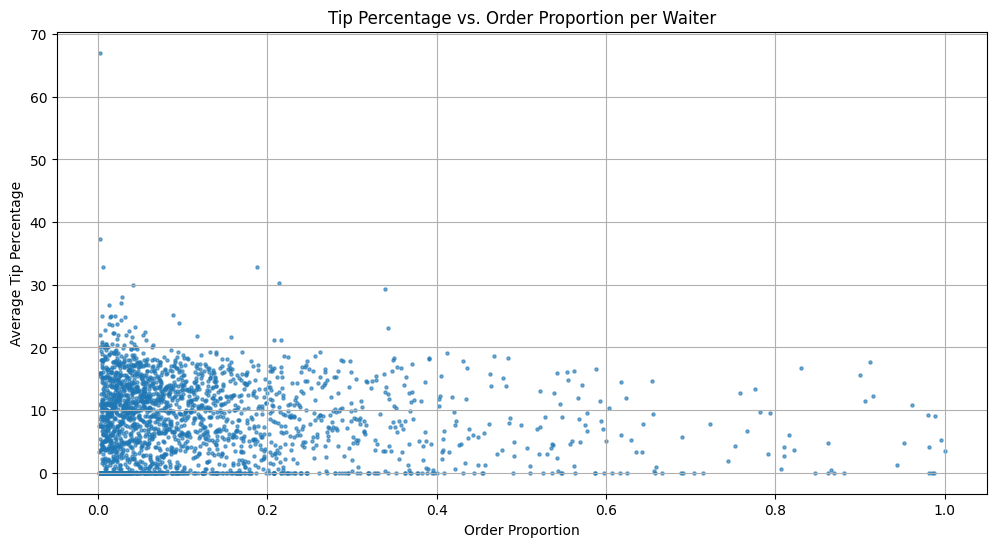

In [9]:
waiter_orders = bills_df.groupby(['venue_xref_id', 'waiter_uuid'])['bill_total_billed'].count().reset_index(name='order_count')
venue_orders = bills_df.groupby('venue_xref_id')['bill_total_billed'].count().reset_index(name='total_orders')
waiter_orders = waiter_orders.merge(venue_orders, on='venue_xref_id')

waiter_orders['order_proportion'] = waiter_orders['order_count'] / waiter_orders['total_orders']

bills_df = bills_df.merge(waiter_orders[['waiter_uuid', 'venue_xref_id', 'order_proportion']], on=['waiter_uuid', 'venue_xref_id'], how='left')
proportion_tip_summary = bills_df.groupby('order_proportion', as_index=False)['tip_percentage'].mean()

plt.figure(figsize=(12, 6))
plt.scatter(proportion_tip_summary['order_proportion'], proportion_tip_summary['tip_percentage'], alpha=0.6, s=5)
plt.xlabel('Order Proportion')
plt.ylabel('Average Tip Percentage')
plt.title('Tip Percentage vs. Order Proportion per Waiter')
plt.grid(True)
plt.show()

# Median income vs. tips

In [11]:
income_df = pd.read_csv('us_income.csv', encoding = "ISO-8859-1")
income_df = income_df.loc[income_df['Median'] != 0].loc[income_df['Median'] != 300000]
income_df['Median'] = income_df.groupby('City')['Median'].transform('mean')
income_df = income_df.drop_duplicates(subset=['City'])


# group by city
us_bills_df = bills_venues_df.loc[bills_venues_df['country'] == 'US']
tips_by_city = us_bills_df.groupby('city').agg(
    average_bill_size=('bill_total_billed', 'mean'),
    average_tip_amount=('payment_total_tip', 'mean'),
    average_tip_percentage=('tip_percentage', 'mean'),
)
tips_by_city = tips_by_city.loc[tips_by_city['average_tip_percentage'] > 0]

# merge tips data with income data
merged_df = pd.merge(tips_by_city, income_df, left_on='city', right_on='City', how='inner')

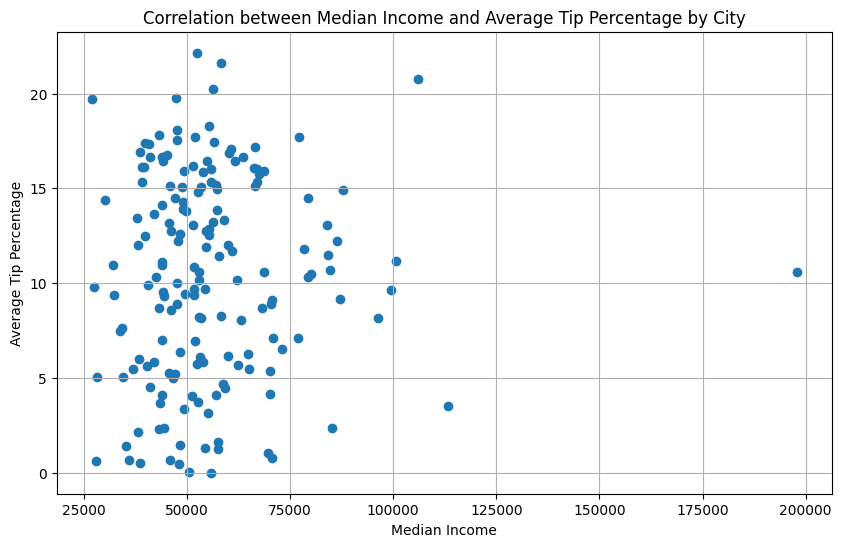

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Median'], merged_df['average_tip_percentage'])
plt.xlabel('Median Income')
plt.ylabel('Average Tip Percentage')
plt.title('Correlation between Median Income and Average Tip Percentage by City')
plt.grid(True)
plt.show()

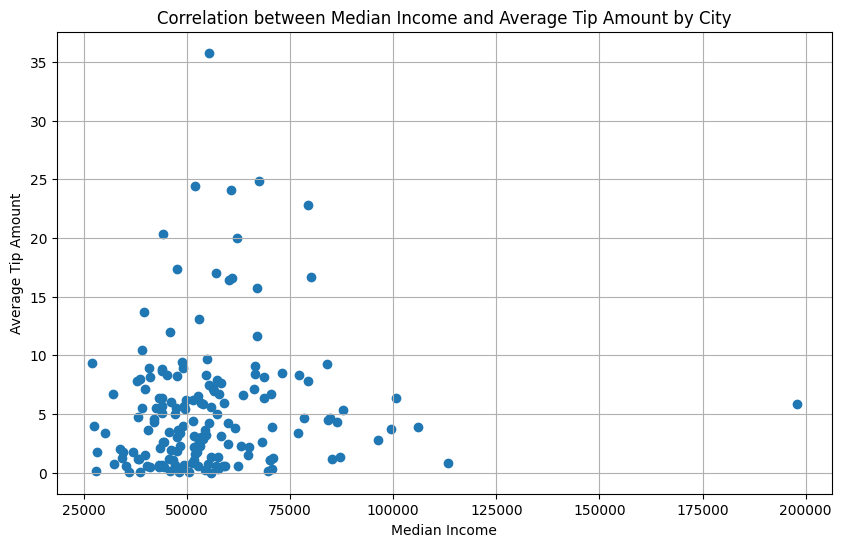

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Median'], merged_df['average_tip_amount'])
plt.xlabel('Median Income')
plt.ylabel('Average Tip Amount')
plt.title('Correlation between Median Income and Average Tip Amount by City')
plt.grid(True)
plt.show()

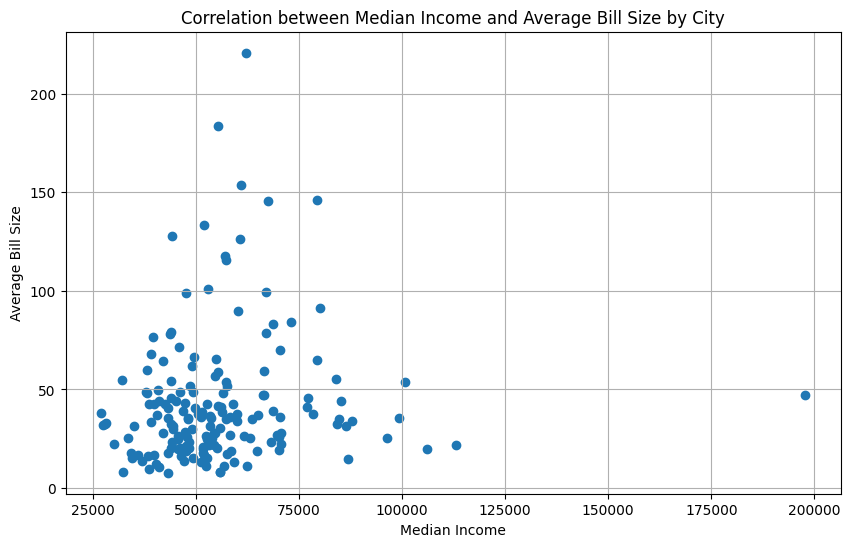

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Median'], merged_df['average_bill_size'])
plt.xlabel('Median Income')
plt.ylabel('Average Bill Size')
plt.title('Correlation between Median Income and Average Bill Size by City')
plt.grid(True)
plt.show()

In [15]:
import numpy as np

# Time of Day vs Tip %
time_of_day_summary = bills_df.groupby('hour_of_day')['tip_percentage'].mean().reset_index()
r_time_of_day = np.corrcoef(time_of_day_summary['hour_of_day'], time_of_day_summary['tip_percentage'])[0, 1]
print(f"R-value for Time of Day vs Tip Percentage: {r_time_of_day}")

# Waiter Proportion vs Tip %
proportion_tip_summary = bills_df.groupby('order_proportion', as_index=False)['tip_percentage'].mean()
r_waiter_proportion = np.corrcoef(proportion_tip_summary['order_proportion'], proportion_tip_summary['tip_percentage'])[0, 1]
print(f"R-value for Waiter Proportion vs Tip Percentage: {r_waiter_proportion}")

# Median Income vs Tip %
r_income_tip_percentage = np.corrcoef(merged_df['Median'], merged_df['average_tip_percentage'])[0, 1]
print(f"R-value for Median Income vs Average Tip Percentage: {r_income_tip_percentage}")

# Median Income vs Tip Amount
r_income_tip_amount = np.corrcoef(merged_df['Median'], merged_df['average_tip_amount'])[0, 1]
print(f"R-value for Median Income vs Average Tip Amount: {r_income_tip_amount}")

# Median Income vs Bill Size
r_income_bill_size = np.corrcoef(merged_df['Median'], merged_df['average_bill_size'])[0, 1]
print(f"R-value for Median Income vs Average Bill Size: {r_income_bill_size}")


R-value for Time of Day vs Tip Percentage: 0.14707072096138923
R-value for Waiter Proportion vs Tip Percentage: nan
R-value for Median Income vs Average Tip Percentage: 0.04672545900541245
R-value for Median Income vs Average Tip Amount: 0.09364302694724974
R-value for Median Income vs Average Bill Size: 0.10799615881227663
